In [4]:
import sunpy.map
import sunpy.visualization.colormaps as cm
import sunpy.sun.constants
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from sunpy.image.resample import resample

import astropy.units as u
from astropy.constants import G, M_sun, R_sun, au
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy.units import imperial
from astropy.stats import gaussian_fwhm_to_sigma

import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import pickle
import numpy as np
import cupy as cp
import pandas as pd
import math
from math import pi
import glob
import time
import datetime
import os
import importlib
import warnings

from PIL import Image
from fpdf import FPDF

from gaussian_fit_aia import gaussian_fit_aia
from calculating_DN import calculating_DN

# Save 1400 maps into a df

I want to construct a df of two col:   time    image(numpy array)


Because win doesn't support cuDF, I have to use pandas.
pandas don't support cupy array.

In [5]:
aia_files=sorted(glob.glob('./data/AIA_1p5/*adjusted.fits'))
len(aia_files)

1460

<sunpy.map.sources.sdo.AIAMap object at 0x00000237DB1D8C70>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 4
Detector:		 AIA
Measurement:		 304.0 Angstrom
Wavelength:		 304.0 Angstrom
Observation Date:	 2010-06-01 00:00:08
Exposure Time:		 1.0 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.6 0.6] arcsec / pix
Reference Pixel:	 [2047.5 2047.5] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[3.30081588e-03, 0.00000000e+00, 0.00000000e+00, ...,
        5.99228092e-06, 0.00000000e+00, 4.23066271e-07],
       [0.00000000e+00, 5.69151174e-02, 2.55237912e-01, ...,
        0.00000000e+00, 5.15415928e-06, 0.00000000e+00],
       [0.00000000e+00, 7.53415413e-02, 4.72392725e-01, ...,
        1.25361319e-04, 0.00000000e+00, 8.97128604e-06],
       ...,
       [0.00000000e+00, 2.95110010e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.23179935e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.37229329e-09, 0.00000000e+00, 8.69919050e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype='>f8')
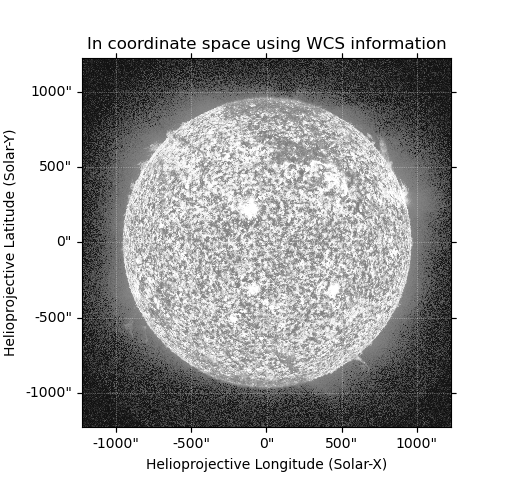
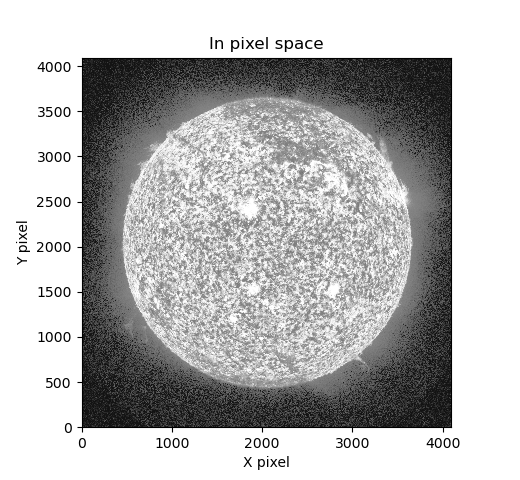
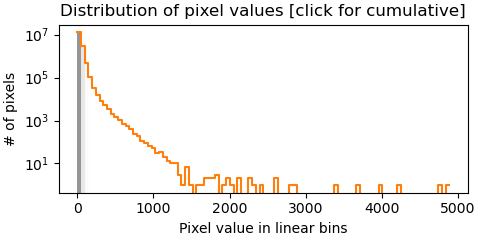
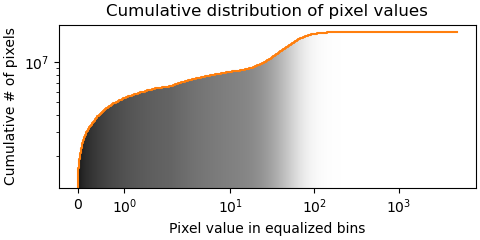

In [6]:
smap=sunpy.map.Map(aia_files[0])
smap

In [51]:
#extract time from map metadata
t=smap.meta['date-obs']
t=pd.to_datetime(t)
t

Timestamp('2010-06-01 00:00:08.120000')

In [52]:
image=smap.data
#downsample image from (4096,4096) into (2048,2048) 
image=resample(image,(2048,2048),method='linear',center=False,minusone = False)
#turn dtype into float16: Range: Approximately ±65504 to ±5.96 × 10^-8
image=image.astype(np.float16)

In [53]:
image

array([[3.3016e-03, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 4.7241e-01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 1.1865e-01, ..., 9.0599e-04, 6.3658e-05,
        4.4703e-06],
       ...,
       [0.0000e+00, 3.5763e-07, 4.7088e-06, ..., 0.0000e+00, 1.1921e-07,
        3.5763e-07],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], dtype=float16)

In [54]:
1.4e3*image.nbytes/(1024**3)        

10.9375

In [61]:
def is_in_float16_range(arr):
    # Get the floating-point info for np.float16
    info_float16 = np.finfo(np.float16)
    
    # Check if all elements in the array are within the range of np.float16
    return np.all((arr >= info_float16.min) & (arr <= info_float16.max))

In [69]:
#expected run time: 7 min
#loop through all files and extract time and image data, then save to a dataframe
df=pd.DataFrame(columns=['time','image'])
time_list=[]
image_list=[]

prob_list=[]

for i in list(range(len(aia_files)))[:]:
    smap=sunpy.map.Map(aia_files[i])
    t=smap.meta['date-obs']
    t=pd.to_datetime(t)
    time_list.append(t)

    image=smap.data
    #downsample image from (4096,4096) into (2048,2048) 
    image=resample(image,(2048,2048),method='linear',center=False,minusone = False)
    #check if image within range of float16
    if not is_in_float16_range(image):
        prob_list.append(aia_files[i])
        print('out of range: '+aia_files[i])

    #turn dtype into float16: Range: Approximately ±65504 to ±5.96 × 10^-8
    image=image.astype(np.float16)
    image_list.append(image)


df['time']=time_list
df['image']=image_list
df['filename']=aia_files

out of range: ./data/AIA_1p5\aia_lev1_304a_2010_06_05t00_00_05_50z_image_lev1_adjusted.fits
out of range: ./data/AIA_1p5\aia_lev1_304a_2010_06_06t00_00_05_50z_image_lev1_adjusted.fits
out of range: ./data/AIA_1p5\aia_lev1_304a_2010_06_07t00_00_05_50z_image_lev1_adjusted.fits
out of range: ./data/AIA_1p5\aia_lev1_304a_2010_06_08t00_00_05_50z_image_lev1_adjusted.fits
out of range: ./data/AIA_1p5\aia_lev1_304a_2010_06_09t00_00_05_50z_image_lev1_adjusted.fits
out of range: ./data/AIA_1p5\aia_lev1_304a_2010_06_10t00_00_05_50z_image_lev1_adjusted.fits
out of range: ./data/AIA_1p5\aia_lev1_304a_2010_07_28t00_00_00_51z_image_lev1_adjusted.fits
out of range: ./data/AIA_1p5\aia_lev1_304a_2010_07_29t00_00_00_51z_image_lev1_adjusted.fits
out of range: ./data/AIA_1p5\aia_lev1_304a_2013_10_24t00_00_10_13z_image_lev1_adjusted.fits


C:\Users\14902\AppData\Local\Temp\ipykernel_28360\2059391559.py:24: RuntimeWarning:

overflow encountered in cast



### Df :   save & read

In [73]:
#save df into pickle file
with open('./data/aia.pkl','wb') as file:
    pickle.dump(aia_df,file)

In [74]:
# load df from pickle file
with open('./data/aia.pkl','rb') as file:
     aia_df=pickle.load(file)

In [75]:
aia_df

time  \
0    2010-06-01 00:00:08.120   
1    2010-06-02 00:05:38.120   
2    2010-06-03 00:00:02.130   
3    2010-06-04 00:00:02.130   
4    2010-06-05 00:00:05.500   
...                      ...   
1455 2014-05-27 00:00:07.140   
1456 2014-05-28 00:00:07.120   
1457 2014-05-29 00:00:07.130   
1458 2014-05-30 00:00:07.120   
1459 2014-05-31 00:00:07.120   

                                                  image  \
0     [[0.003302, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001377,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.276e-05...   
2     [[0.0, 0.0, 3.535e-05, 0.0, 0.0, 5.496e-05, 0....   
3     [[0.0, 0.0, 0.0, 0.0004733, 0.0, 0.0, 0.0, 0.0...   
4     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
...                                                 ...   
1455  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1456  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1457  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1458  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1459  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                               filename  
0     ./data/AIA_1p5\aia_lev1_304a_2010_06_01t00_00_...  
1     ./data/AIA_1p5\aia_lev1_304a_2010_06_02t00_05_...  
2     ./data/AIA_1p5\aia_lev1_304a_2010_06_03t00_00_...  
3     ./data/AIA_1p5\aia_lev1_304a_2010_06_04t00_00_...  
4     ./data/AIA_1p5\aia_lev1_304a_2010_06_05t00_00_...  
...                                                 ...  
1455  ./data/AIA_1p5\aia_lev1_304a_2014_05_27t00_00_...  
1456  ./data/AIA_1p5\aia_lev1_304a_2014_05_28t00_00_...  
1457  ./data/AIA_1p5\aia_lev1_304a_2014_05_29t00_00_...  
1458  ./data/AIA_1p5\aia_lev1_304a_2014_05_30t00_00_...  
1459  ./data/AIA_1p5\aia_lev1_304a_2014_05_31t00_00_...  

[1460 rows x 3 columns]

# Image

In [68]:
'./data/sep_png/'+png_name+'.png'

'./data/sep_png/2010-06-01 00:00:08.120000.png'

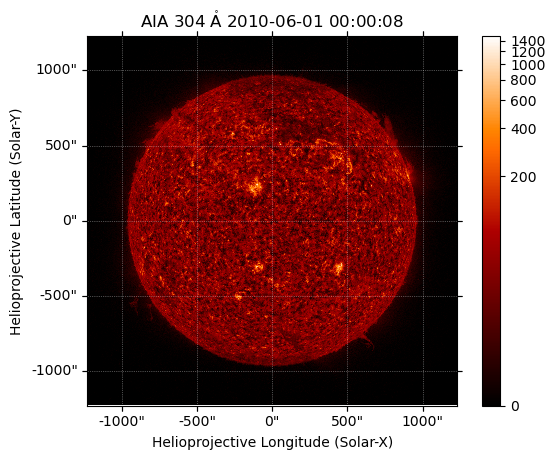

In [69]:
smap=sunpy.map.Map(df['filename'][0])
fig=plt.figure()
ax = fig.add_subplot(projection=smap)
smap.plot(ax,vmax=1500,vmin=0)
plt.colorbar()

#save png
png_name=df['time'][0].strftime('%Y%m%d%H%M%S')
plt.savefig('./data/sep_png/'+png_name+'.png')
# plt.close(fig)

### 1400 Png

In [7]:
png_list=[]
#save 1400 images into pngs
for i in list(range(len(aia_df)))[:800]:
    smap=sunpy.map.Map(aia_df['filename'][i])
    fig=plt.figure()
    ax = fig.add_subplot(projection=smap)
    smap.plot(ax,vmax=1500,vmin=0)
    plt.colorbar()
    plt.tight_layout()
    #save png
    png_name=aia_df['time'][i].strftime('%Y%m%d%H%M%S')
    png_path='.//data//sep_png//'+png_name+'.png'
    png_list.append(png_path)
    plt.savefig(png_path,dpi=100)
    plt.close(fig)

In [10]:
#save 1400 images into pngs
for i in list(range(len(aia_df)))[800:]:
    smap=sunpy.map.Map(aia_df['filename'][i])
    fig=plt.figure()
    ax = fig.add_subplot(projection=smap)
    smap.plot(ax,vmax=1500,vmin=0)
    plt.colorbar()
    plt.tight_layout()
    #save png
    png_name=aia_df['time'][i].strftime('%Y%m%d%H%M%S')
    png_path='.//data//sep_png//'+png_name+'.png'
    png_list.append(png_path)
    plt.savefig(png_path,dpi=100)
    plt.close(fig)

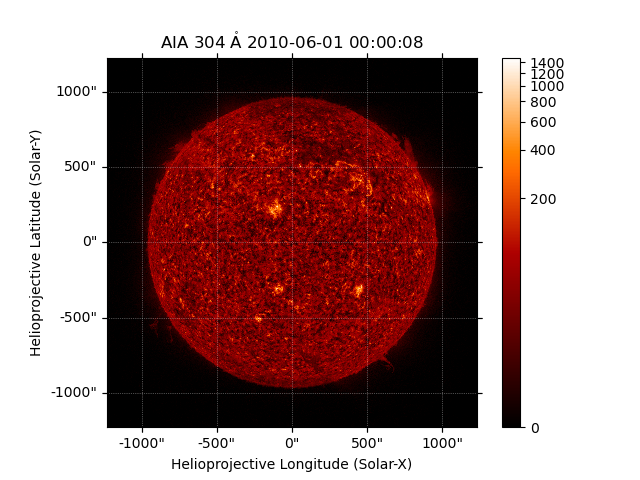

In [73]:
from IPython.display import Image, display

# Replace 'path/to/your/image.png' with the actual path to your PNG image
image_path = 'data\\sep_png\\20100601000008.png'

# Display the image below the cell
display(Image(filename=image_path))

### PDF

In [2]:
#save four year sun images into a pdf
def convert_images_to_pdf(image_folder, output_path, columns, rows):
    # Get a list of all PNG files in the folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]


    
    # Create a new PDF document
    pdf = FPDF()

    # Set the page size to A4 in landscape mode
    pdf.set_auto_page_break(auto=True, margin=0)
    pdf.add_page(orientation='P')
    pdf.add_page(orientation='P')
        
    # Calculate the number of grid cells per page
    cells_per_page = columns * rows

    # Define the width and height of each image in the grid
    grid_width = pdf.w / columns
    grid_height = pdf.h / rows

    # Iterate over each image file
    for index, image_file in enumerate(image_files):
        # Open the image using PIL
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)

        # Convert the image to RGB mode if it's not already
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Resize the image to fit within the grid
        image.thumbnail((grid_width, grid_height))

        # Calculate the position of the current grid cell
        x = (index % columns) * grid_width
        y = ((index // columns)%rows)  * grid_height
        
        # Add the image to the current page
        pdf.image(image_path, x=x, y=y, w=image.width, h=image.height)
        
        # If we have added the desired number of images per page, start a new page
        if index != 0 and (index + 1) % cells_per_page == 0:
            pdf.add_page(orientation='P')

    pdf.add_page(orientation='P') 
    # Save the PDF file
    pdf.output(output_path)

In [3]:
# Specify the folder containing the PNG files, the output PDF path, columns, and rows
image_folder = './data/sep_png'
# image_folder = './data/test/'

output_pdf = './data/uni_pdf/aia_years_P.pdf'
num_columns = 4
num_rows = 8

# Call the function to convert the images to PDF with the specified grid layout
convert_images_to_pdf(image_folder, output_pdf, num_columns, num_rows)

## Img MSE

'./data/AIA_1p5\\aia_lev1_304a_2013_10_24t00_00_10_13z_image_lev1_adjusted.fits'

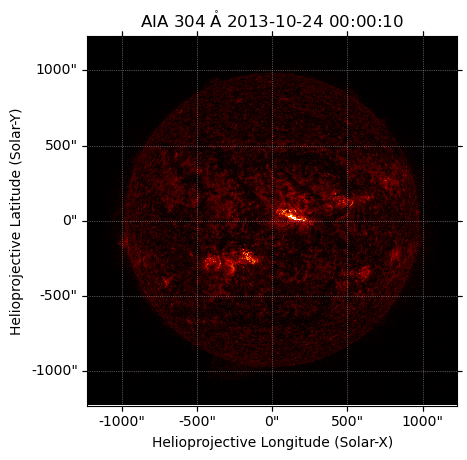

In [78]:
# flare   so bright
smap=sunpy.map.Map(aia_df['filename'][1240])
fig=plt.figure()
ax = fig.add_subplot(projection=smap)
smap.plot(ax,vmax=1e4,vmin=0)

aia_df['filename'][1240]

In [8]:
n=len(aia_df)
# n=100
mse_matrix=np.full((n,n),np.nan)
for i in range(n):
    img1=cp.asarray(aia_df['image'][i],dtype=cp.float32)
    for j in np.arange(i,n):
        
        img2=cp.asarray(aia_df['image'][j],dtype=cp.float32)
        mse_matrix[i,j]=cp.mean((img1-img2)**2)

mse_matrix=cp.asnumpy(mse_matrix)
np.savez('./data/mse_matrix.npz',mse_matrix=mse_matrix)

In [27]:
time_list=aia_df['time'].tolist()

In [46]:
# check where is inf
np.where(np.isinf(mse_matrix))

(array([   0,    1,    2, ..., 1240, 1240, 1240], dtype=int64),
 array([1240, 1240, 1240, ..., 1457, 1458, 1459], dtype=int64))

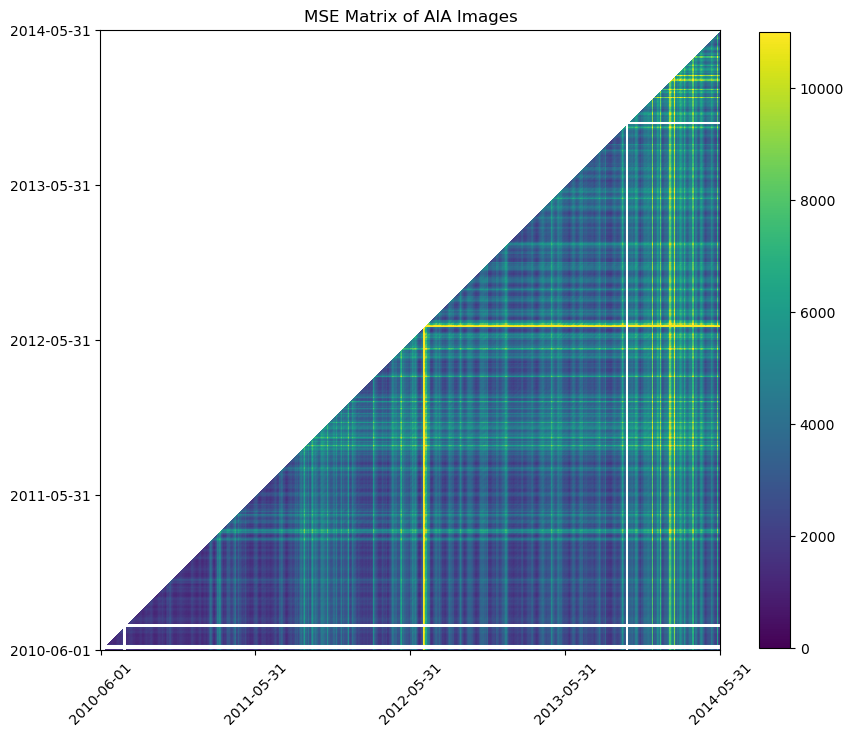

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
im=ax.imshow(mse_matrix,vmin=0,vmax=11e3,origin='lower')

# set x,y tick to be time list
x_tick_list=np.linspace(0,n-1,5,dtype=int)
x_tick_label=[time_list[i].to_pydatetime().date() for i in x_tick_list]
ax.set_xticks(x_tick_list)
ax.set_xticklabels(x_tick_label,rotation=45)

y_tick_list=np.linspace(0,n-1,5,dtype=int)
y_tick_label=[time_list[i].to_pydatetime().date() for i in y_tick_list]
ax.set_yticks(y_tick_list)
ax.set_yticklabels(y_tick_label)

# set title
ax.set_title('MSE Matrix of AIA Images')

fig.colorbar(im,ax=ax,shrink=0.8)
fig.savefig('./fig/mse_matrix_3000.png',dpi=3000)

In [101]:
a,b=np.where(mse_matrix>1e4)

In [104]:
# given a 1D array,fing the elements that appear more than 10 times
def find_dup(arr):
    unique, counts = np.unique(arr, return_counts=True)
    dup=unique[counts>400]
    return dup

# find the elements that appear more than 10 times
dup=find_dup(a)
dup


array([480, 499, 584, 762, 764, 767], dtype=int64)

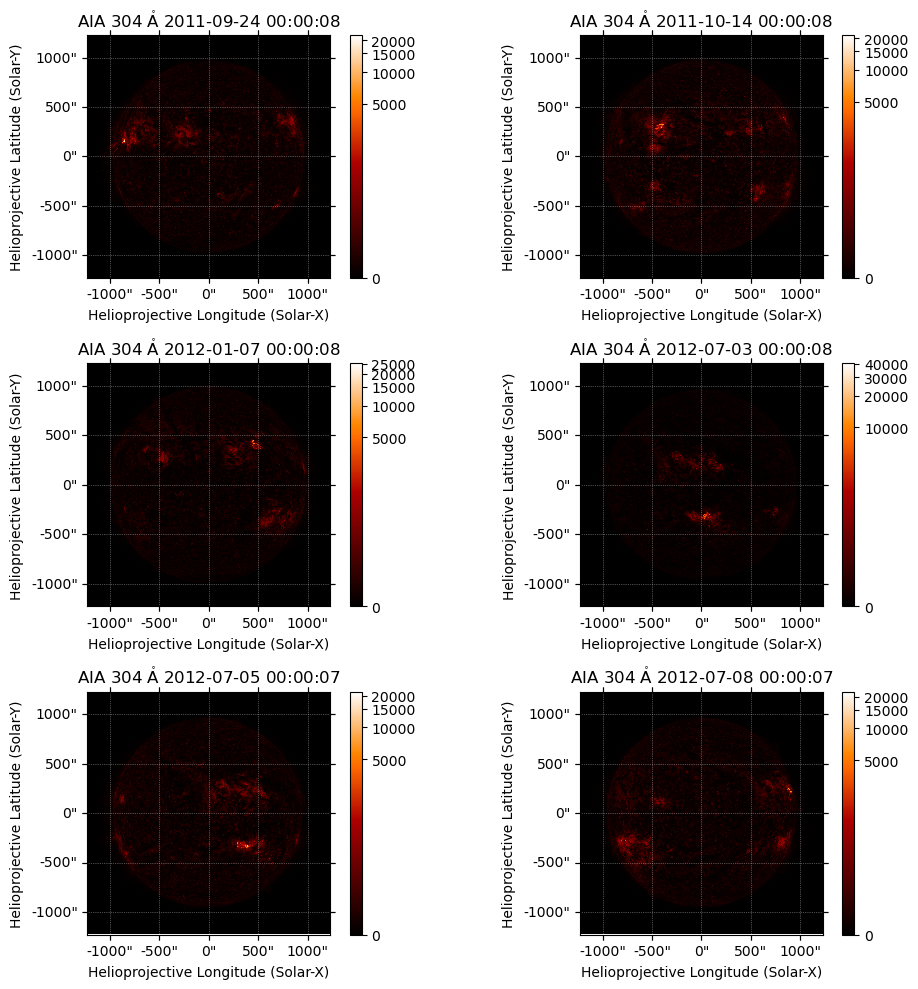

In [120]:
# imshow the image with the most duplicates, whose index is in list dup
# duplicates means  the brightest image
files=aia_df['filename'][dup].tolist()
smaps=[sunpy.map.Map(file) for file in files]
fig=plt.figure(figsize=(10,10))
for i in range(len(smaps)):
    ax=fig.add_subplot(len(smaps)//2,2,i+1,projection=smaps[i])
    smaps[i].plot(ax
                #   ,vmax=1500,vmin=0
                  )
    plt.colorbar()

plt.tight_layout()

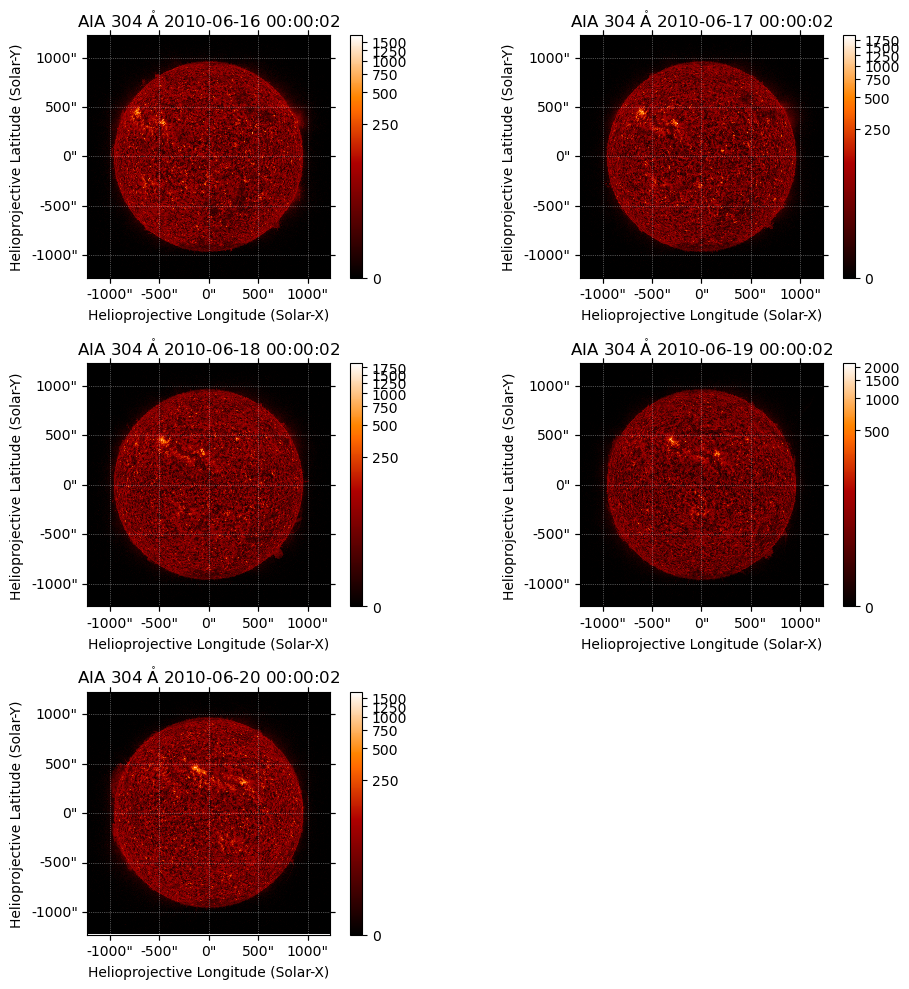

In [127]:
# normal img

files=aia_df['filename'][np.arange(15,20)].tolist()
smaps=[sunpy.map.Map(file) for file in files]
fig=plt.figure(figsize=(10,10))
for i in range(len(smaps)):
    ax=fig.add_subplot((len(smaps)+1)//2,2,i+1,projection=smaps[i])
    smaps[i].plot(ax
                #   ,vmax=1500,vmin=0
                  )
    plt.colorbar()

plt.tight_layout()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [88]:
a[11001]

762

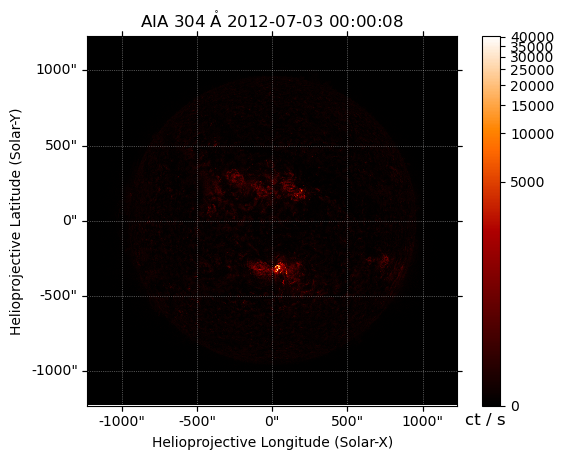

In [89]:
smap=sunpy.map.Map(aia_df['filename'][a[11000]])
smap.peek()

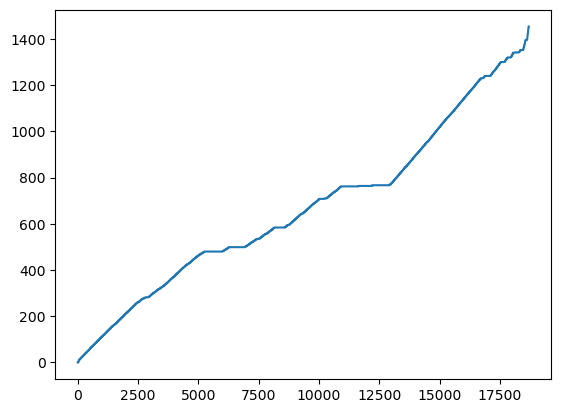

In [86]:
plt.plot(a)

## calculate DN

In [9]:
importlib.reload(aia_part.calculate_DN)
from aia_part.calculate_DN import calculate_DN

NameError: name 'aia_part' is not defined

In [ ]:
a=datetime.datetime(2010,6,11).date()

In [8]:
calculating_DN(smap)

TypeError: calculating_DN() missing 3 required positional arguments: 'wavelength_list', 'offaxis_angle_x', and 'offaxis_angle_y'

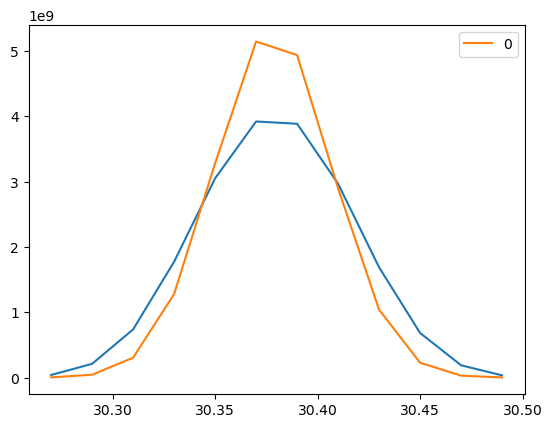

In [ ]:
b=calculate_DN(aia_adjusted_map,0,0,0)
fig,ax=plt.subplots()
ax.plot(wavelength_list_aia_absolute,a)
ax.plot(wavelength_list_aia_absolute,b,label='0')
gaussian_fit_aia(wavelength_list_aia_absolute,a)
ax.legend()

### Radial velocity : 地球椭圆轨道的径向速度

In [ ]:
def calculate_relative_radial_velocity(time):
    # Convert the input time to an Astropy Time object

    t = Time(time)

    # Get the barycentric position and velocity of the Earth
    earth_posvel = get_body_barycentric_posvel('earth', t)
    # Get the barycentric position and velocity of the Sun
    sun_posvel = get_body_barycentric_posvel('sun', t)

    # Calculate the relative position of the Earth with respect to the Sun
    relative_pos = earth_posvel[0] - sun_posvel[0]
    # Calculate the relative velocity of the Earth with respect to the Sun
    relative_vel = earth_posvel[1] - sun_posvel[1]

    # Calculate the radial component of the relative velocity
    radial_velocity = (relative_pos.get_xyz() * relative_vel.get_xyz()).sum() / relative_pos.norm()
    # Convert the velocity to km/s
    radial_velocity = radial_velocity.to(u.km/u.s)

    return radial_velocity

In [ ]:
def calculate_relative_radial_velocity(time_list):
    radial_velocity_list=[]
    # Convert the input time to an Astropy Time object
    for time in time_list:
        t = Time(time)

        # Get the barycentric position and velocity of the Earth
        earth_posvel = get_body_barycentric_posvel('earth', t)
        # Get the barycentric position and velocity of the Sun
        sun_posvel = get_body_barycentric_posvel('sun', t)

        # Calculate the relative position of the Earth with respect to the Sun
        relative_pos = earth_posvel[0] - sun_posvel[0]
        # Calculate the relative velocity of the Earth with respect to the Sun
        relative_vel = earth_posvel[1] - sun_posvel[1]

        # Calculate the radial component of the relative velocity
        radial_velocity = (relative_pos.get_xyz() * relative_vel.get_xyz()).sum() / relative_pos.norm()
        # Convert the velocity to km/s
        radial_velocity = radial_velocity.to(u.km/u.s)

        radial_velocity_list.append(radial_velocity.value)
    return radial_velocity_list

In [ ]:
start_date = datetime.datetime(2011,1,1,0,0,0)
end_date = datetime.datetime(2012,1,1,0,0,0)
date_list = pd.date_range(start=start_date, end=end_date,freq='D').tolist()

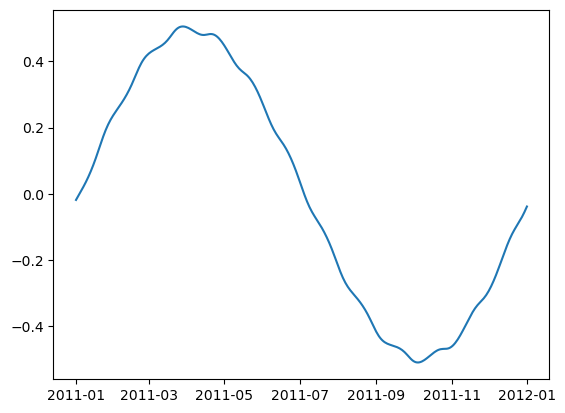

In [ ]:
fig,ax=plt.subplots()
ax.plot(date_list,calculate_relative_radial_velocity(date_list))

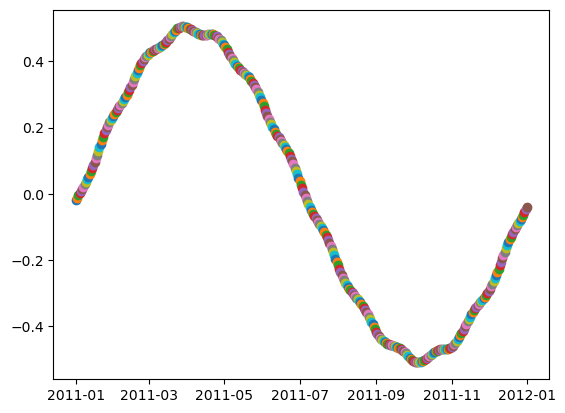

In [ ]:
fig,ax=plt.subplots()
for d in date_list:
    ax.scatter(d,calculate_relative_radial_velocity(d))

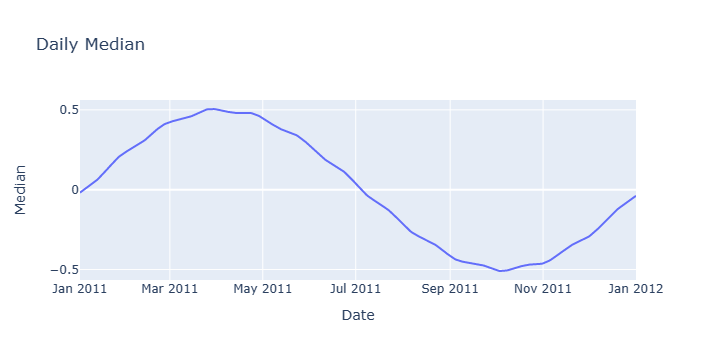

In [ ]:
fig = go.Figure(data=go.Scatter(x=date_list, y=calculate_relative_radial_velocity(date_list)))
fig.update_layout(title="Daily Median", xaxis_title="Date", yaxis_title="Median")
fig.show()

In [ ]:
calculate_relative_radial_velocity(d)

<Quantity -0.03831708 km / s>

In [ ]:
(calculate_relative_radial_velocity(d) ).to(u.nm, equivalencies=u.doppler_optical(30.3783 * u.nm)).value-30.3783

-3.882711947511552e-06

## Parameters

$$
\Delta \lambda=a  T_x^2 + b  T_x+cT_y^2+d T_y+e
$$

In [ ]:
angular_radius=sunpy.sun.constants.get('average angular size')
angular_radius=angular_radius.to(u.rad)
#角度遍布整个日面
Tx=np.linspace(-angular_radius,angular_radius,200)
Ty=np.linspace(-angular_radius,angular_radius,200)

def para_visual3(a=8.86e2,d=0.91):
    fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(12,12))
    axs[0,0].plot(Tx.to(u.arcmin),a*Tx**2,label=f'$\Delta \lambda=a  T_x^2$    a={a}',c='b')
    # axs[0,0].plot(Tx.to(u.arcmin),0*Tx,label=r'$\Delta \lambda=b  T_x$',c='b')
    # axs[0,1].plot(Ty.to(u.arcmin),0*Ty**2,label=r'$\Delta \lambda=cT_y^2$',c='g')
    axs[0,1].plot(Ty.to(u.arcmin),d*Ty,label=f'$\Delta \lambda=d T_y$     d={d}',c='g')
    
    # y_min, y_max = axs[0].get_ylim()
    axs[0,0].set_ylim(min(axs[0,0].get_ylim()[0],axs[0,1].get_ylim()[0]), 
                      max(axs[0,0].get_ylim()[1],axs[0,1].get_ylim()[1]))


    axs[0,0].set_ylabel(r'$\Delta \lambda$  (nm)')
    axs[0,0].set_xlabel('Tx (rad)')
    axs[0,1].set_xlabel('Ty (rad)')
    axs[0,1].set_yticklabels([])
    axs[0,1].set_ylabel('')
    axs[0,0].set_title(f'expected optial correction for each pixel: a={a}  d={d}')
    plt.subplots_adjust(wspace=0)
    axs[0,0].legend()
    axs[0,1].legend()


    aia_adjusted_files=sorted(glob.glob('aia_part/data/AIA_1p5/*adjusted.fits'))
    aia_adjusted_map=sunpy.map.Map(aia_adjusted_files[10])


    axs[1,0].plot(wavelength_list_aia_absolute,
            calculate_DN(aia_adjusted_map,a,d,0),
           label=f'a={a}   d={d}')
    axs[1,0].plot(wavelength_list_aia_absolute,
            calculate_DN(aia_adjusted_map,0,0,0),label='ideal condition: optically perfect')
    axs[1,0].legend()
    axs[1,0].set_xlabel('wavelength (nm)')
    axs[1,0].set_title('full image spectrum')

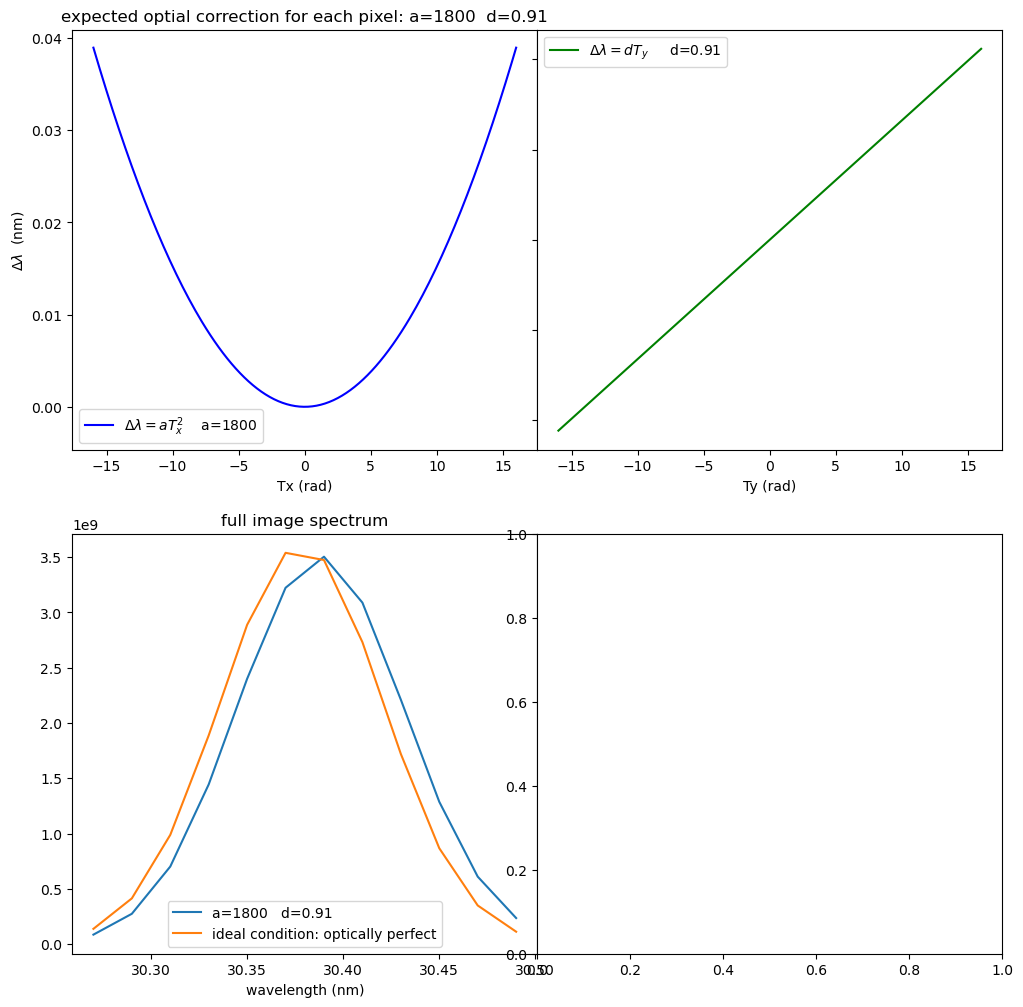

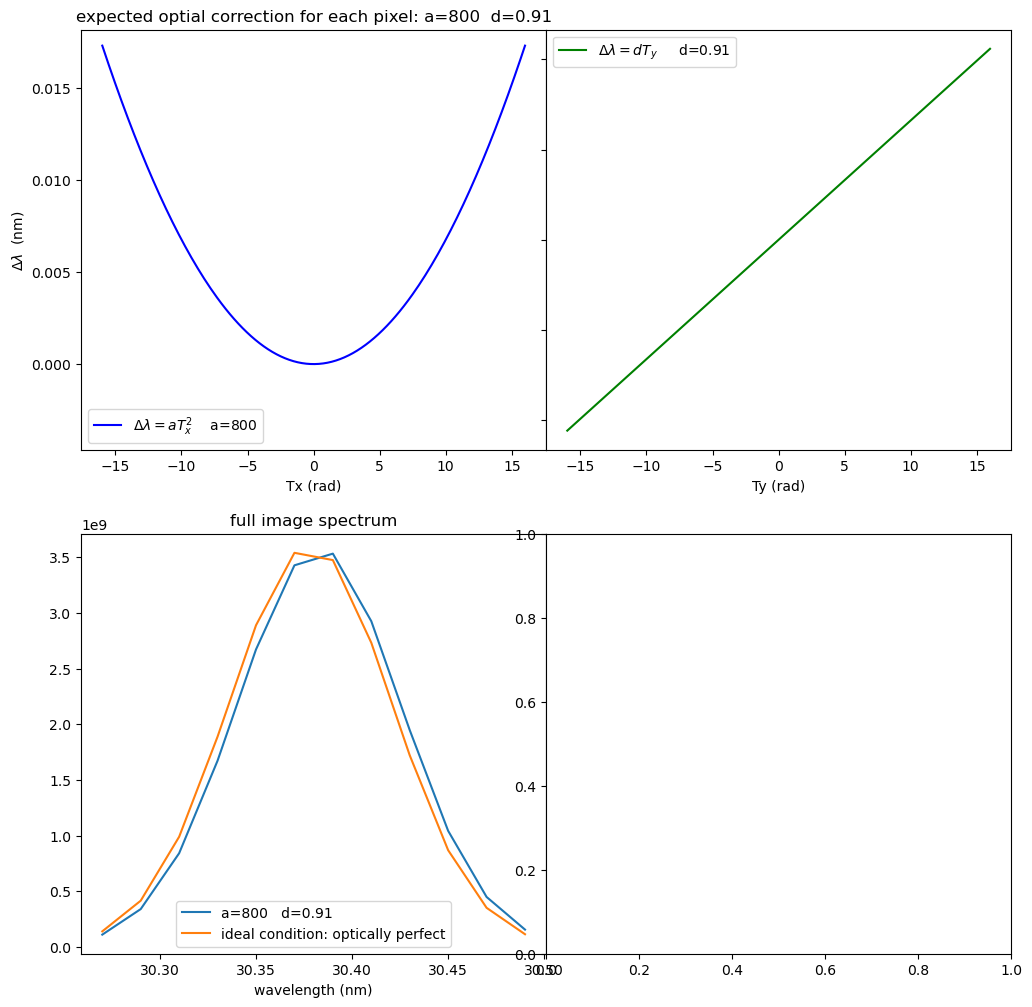

In [ ]:
para_visual3(a=1800,d=0.91)
para_visual3(a=800,d=0.91)

### 3d visual

In [ ]:
time=datetime.datetime.strptime(aia_adjusted_map.meta['t_rec'],'%Y-%m-%dT%H:%M:%SZ')
date=time.date()
time

NameError: name 'aia_adjusted_map' is not defined

In [ ]:
aia_adjusted_maps=[]
for file in aia_adjusted_files[500:510]:
    aia_adjusted_maps.append(sunpy.map.Map(file))

In [ ]:
irradiance_list=[]
date_list=[]
for m in aia_adjusted_maps:
    date,irradiance=calculate_DN(m,a=0,d=0,e=0)
    irradiance_list.append(irradiance)
    date_list.append(date)
irradiance_list=np.array(irradiance_list)

In [ ]:
irradiance_list

[(datetime.datetime(2011, 10, 15, 0, 0),
  array([3.79583727e+06, 3.36917269e+07, 1.91742855e+08, 6.99673356e+08,
         1.63701144e+09, 2.45577357e+09, 2.36213742e+09, 1.45680770e+09,
         5.76075659e+08, 1.46061937e+08, 2.37451443e+07, 2.47510030e+06])),
 (datetime.datetime(2011, 10, 16, 0, 0),
  array([3.77913880e+06, 3.35437420e+07, 1.90901968e+08, 6.96609721e+08,
         1.62985469e+09, 2.44505410e+09, 2.35184280e+09, 1.45046862e+09,
         5.73572888e+08, 1.45428365e+08, 2.36423074e+07, 2.46439789e+06])),
 (datetime.datetime(2011, 10, 17, 0, 0),
  array([3.81217736e+06, 3.38372171e+07, 1.92573448e+08, 7.02713679e+08,
         1.64414697e+09, 2.46651124e+09, 2.37249764e+09, 1.46321691e+09,
         5.78617896e+08, 1.46708489e+08, 2.38505751e+07, 2.48612349e+06])),
 (datetime.datetime(2011, 10, 18, 0, 0),
  array([3.82800832e+06, 3.39779458e+07, 1.93375566e+08, 7.05645058e+08,
         1.65101585e+09, 2.47683120e+09, 2.38243910e+09, 1.46935737e+09,
         5.81049719e+08,

In [ ]:
np.shape(irradiance_list)

(10, 12)

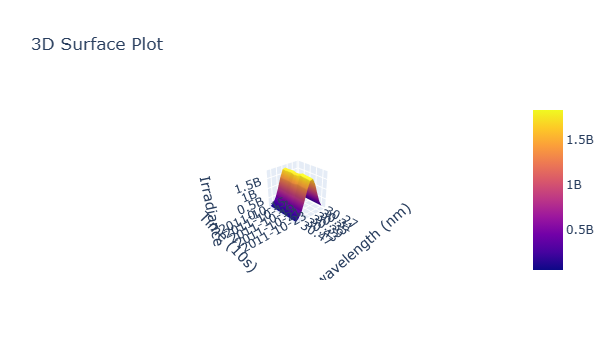

In [ ]:
# Generate x and y coordinates for the surface plot
x = np.arange(np.shape(irradiance_list)[1])
y = np.arange(np.shape(irradiance_list)[0])
X, Y = np.meshgrid(x, y)

# Create the surface plot
fig = go.Figure(data=[go.Surface(x=X,y=Y,z=irradiance_list )])

# Customize the layout
fig.update_layout(
    title='3D Surface Plot',
    # width=550, 
    height=700,
    scene=dict(
        xaxis=dict(
            title='wavelength (nm)',
            ticktext=wavelength_list_aia_absolute[::2],  # Set the desired tick labels
            tickvals=x[::2],  # Use the x coordinates as tick values
        ),
        yaxis=dict(title='Time (10s)',
                   ticktext=date_list[::len(date_list)//5],
                  tickvals=y[::len(y)//5]),
        zaxis=dict(title='Irradiance')
    ),
    # margin=dict(l=0,r=20)
)
fig.show()

## Gaussian fit : time serial

In [ ]:
def select_files(start_date,end_date):
    # Directory containing the files
    directory = "aia_part/data/AIA_1p5"

    # List to store the files within the time range
    files_within_range = []

    # Iterate through all the files in the directory
    for filename in os.listdir(directory):
        # Extract the date portion from the file name
        date_str = filename.split("_")[3]+filename.split("_")[4]+filename.split("_")[5].split('t')[0]  # Assuming the date is in the 5th position

        # Convert the date string to a datetime object
        file_date = datetime.datetime.strptime(date_str, "%Y%m%d")

        # Check if the file date is within the specified range
        if start_date <= file_date <= end_date:
            files_within_range.append(
                os.path.join(directory,filename)
                                    )
    return files_within_range

In [ ]:
def get_simu(start_date,end_date,a,b,c,d,e):
    selected_files=select_files(start_date,end_date)
    
    date_list = pd.date_range(start=start_date, end=end_date,freq='D').tolist()
    mean_list=[]
    stddev_list=[]
    amplitude_list=[]


    for file in select_files(start_date,end_date):
        aia_adjusted_map=sunpy.map.Map(file)
        irradiance=calculate_DN(aia_adjusted_map,a=900,d=0.9,e=0)

        mean,stddev,amplitude=gaussian_fit_aia(wavelength_list_aia_absolute,irradiance)
        mean_list.append(mean)
        stddev_list.append(stddev)
        amplitude_list.append(amplitude)
        
        
        
    simu_data={
        'date':date_list,
        'mean':mean_list,
        'stddev':stddev_list,
        'amplitude':amplitude_list,
    }
    # print(date_list)
    # print(mean_list)
    # print(stddev_list)
    # print(amplitude_list)
    
    simu_df=pd.DataFrame(simu_data)
    simu_df=simu_df.set_index('date')
    return simu_df

In [ ]:
start_date = datetime.datetime(2011, 1, 20)
end_date = datetime.datetime(2011, 3, 1)
simu_df=get_simu(start_date,end_date,a=900,b=0,c=0,d=0.9,e=-0.015)

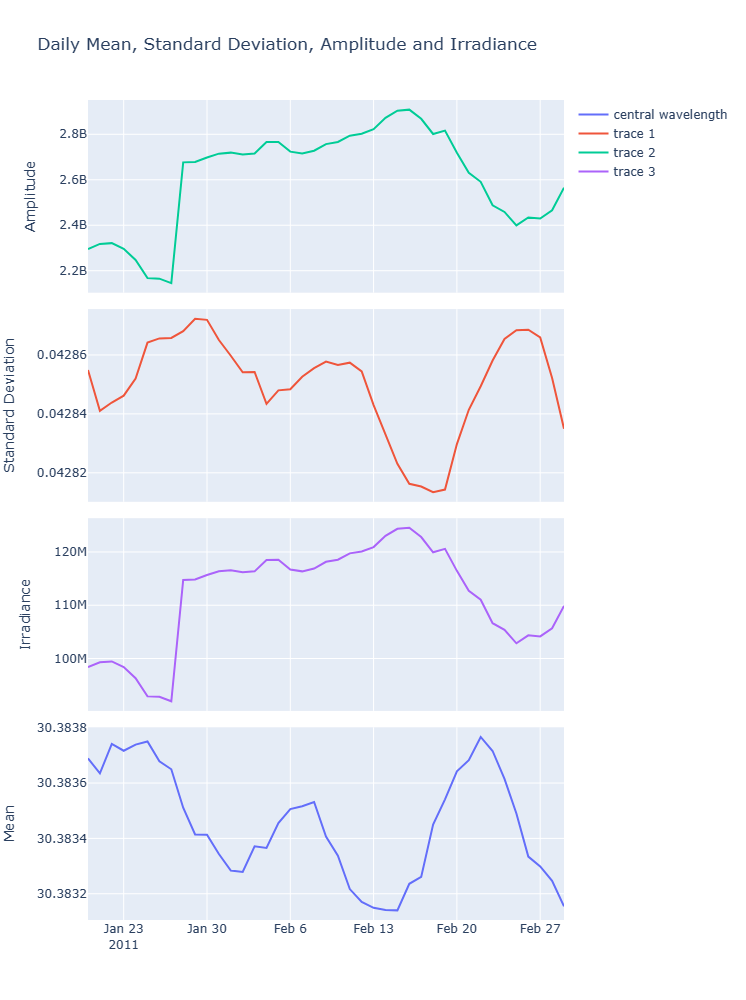

In [ ]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add traces for mean
fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['mean'],name='central wavelength'), 
              row=4, col=1,)
fig.update_yaxes(title_text="Mean", row=4, col=1)

# Add traces for stddev
fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['stddev'])
              , row=2, col=1)
fig.update_yaxes(title_text="Standard Deviation", row=2, col=1)

# Add traces for amplitude
fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['amplitude'])
              , row=1, col=1)
fig.update_yaxes(title_text="Amplitude", row=1, col=1)

# Add traces for irradiance
fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['stddev']*simu_df['amplitude'])
              , row=3, col=1)
fig.update_yaxes(title_text="Irradiance", row=3, col=1)



# Update the figure layout
fig.update_layout(width=600,height=1000,
                  title_text="Daily Mean, Standard Deviation, Amplitude and Irradiance")

# Show the figure
fig.show()

In [ ]:
gaussian_fit_aia(wavelength_list_aia_absolute,
                 calculate_DN(aia_adjusted_map,a=900,d=0.9,e=0))

(30.38329487335242, 0.042822733164858, 3196463126.09203)

In [ ]:
aia_adjusted_map=sunpy.map.Map(aia_adjusted_files[400])
gaussian_fit_aia(wavelength_list_aia_absolute,
                 calculate_DN(aia_adjusted_map,a=900,d=0.9,e=0))

(30.38308106977512, 0.04280780582407995, 1691712891.8304818)

In [ ]:
importlib.reload(aia_part.gaussian_fit_aia )
from aia_part.gaussian_fit_aia import gaussian_fit_aia

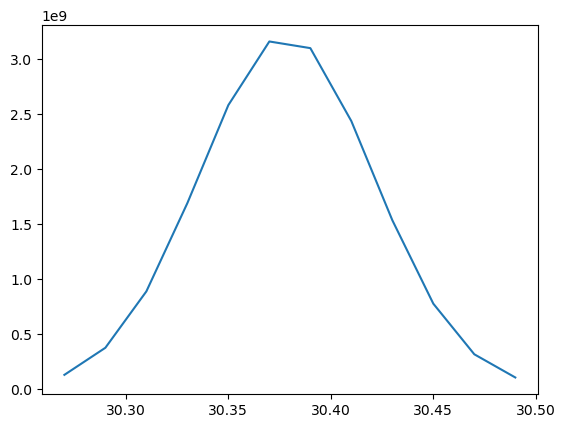

In [ ]:
plt.plot(wavelength_list_aia_absolute,calculate_DN(aia_adjusted_map))

In [ ]:
gaussian_fwhm_to_sigma

0.42466090014400953

## STDDEV discussion

In [ ]:
from chempy import Substance
from scipy.constants import Avogadro,Boltzmann,c

substance = Substance.from_formula('He')  # Specify the chemical formula
molecular_mass = substance.mass/Avogadro 
print(molecular_mass) 

6.646476991348174e-24


In [ ]:
c

299792458.0

In [ ]:

mean=30.37
T=6000
stddev=2*mean*np.sqrt(2*np.log(2)*Boltzmann*T/(molecular_mass*c**2))

In [ ]:
# Doppler 展宽
def FWHM(T):
    return 2*mean*np.sqrt(2*np.log(2)*Boltzmann*T/(molecular_mass*c**2))

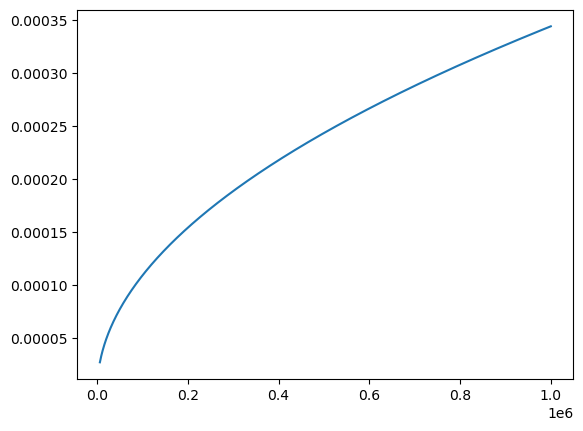

In [ ]:
T=np.linspace(6e3,1e6,1000)
fig,ax=plt.subplots()
ax.plot(T,FWHM(T))

In [ ]:
# 碰撞线宽 看起来比较靠谱
def FWHM(T):
    return 4*(1.7e-10)**2 *1e16*0.1*np.sqrt(Boltzmann*T/(np.pi*molecular_mass))

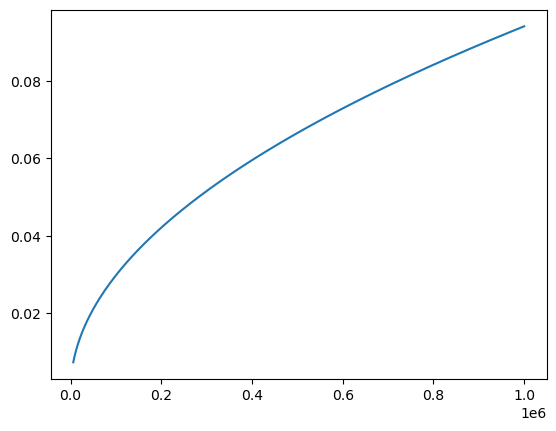

In [ ]:
T=np.linspace(6e3,1e6,1000)
fig,ax=plt.subplots()
ax.plot(T,FWHM(T))

## unit conversion in Ch3

In [ ]:
import astropy.units as u
from astropy.constants import au, R_sun
from astropy.stats import gaussian_fwhm_to_sigma
import math


# %%
print(19.8 * (180*3600/(974.634085*math.pi))**2 / 1000)
print(4.3*180*3600/(974.634085*math.pi*1000))

# %%
print(18.66 * (180*3600/(974.634085*math.pi))**2 / 1000)

886.8134384080664
0.9100222129646885
835.7544828633595
